# COGS 108 - Final Project

# Overview

In this project, various linear models were created to examine the relationships between various economic and demographic factors, and the rates of violations in health inspections within their given regions. The rates of violation were created from the raw datasets of violations and inspections, which were then merged with information for each postal code. After analysis, the rates of violations per health inspection were found to be mostly uncorrelated with income rates and percentage of non-white residents. 

# Name & GitHub

- Name: Calvin Ho
- GitHub Username: ck-ho

# Research Question

Is there a relationship the quantity of health inspection violations and restaurants located in economically poorer areas?

## Background and Prior Work

The burden of authenticity is often accompanied by the burden of humble roots. In other words, there is a growing interest in the notion that cheap food equals authentic (i.e good) food. In the same way that reference 3 uses health inspection grade as an inverse of quality, ethnic diversity and socioeconomic circumstance are often applied in peoples' interest in restaurants. A study performed, reference 1, suggests that "Although the FDA suggests that inspection scores are a proxy measure for restaurant food safety, research has not demonstrated a relationship between restaurant inspection scores and the burden of foodborne illness." This study found significant differences in health inspection between chain and non-chain restaurants. Therefore, this project is intended to explore the possibility of systemic bias in health inspection within areas of different socioecomic circumstance.

References (include links):
- 1)https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5349477/
- 2)https://www.alhambrasource.org/story/aamericanized-bbetter-cchinese-the-abcs-of-san-gabriel-valley-chinese-restaurants

# Hypothesis

I hypothesize that restaurants located in areas of lower income will receive lower health inspection grades or higher rates of infractions, depending on the system used. I believe that this pattern will show especially in health inspection that is performed due to consumer complaint. 

# Dataset(s)

- Dataset Name: violations.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/download?wrap=1
- Number of observations: 189802

The violations dataset contained a unique entry for every violation found by an inspector, with comments, a short description, and a violation code.

- Dataset Name: inspections.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/download?wrap=1
- Number of observations: 18466

The inspections dataset contained a unique entry for each unique inspection, along with a date and the number of violations found. In addition, the number and type of violations was given for neighboring restaurants.

- Dataset Name: zipcodes.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/download?wrap=1
- Number of observations: 38

The zipcodes dataset contained economic and demographic information for various zip codes within the greater Raleigh, NC area. The information included categories such as income, poverty rate, and the percentange of non-white residents.

I intend to combine these three datasets into a singular dataframe where most of the information is broken down by zipcode. I would include the number of inspections, violations, violations per inspection to control for the number of restaurants, along with the economic and demographic data.

# Setup

In [1]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Data Cleaning

In [3]:
inspections = pd.read_csv('inspections.csv')
violations = pd.read_csv('violations.csv')
zipcodes = pd.read_csv('zipcodes.csv')

In [4]:
violations = violations.drop(columns=['X.objectid','inspectdate','statecode','questionno','violationcode','severity'
                            ,'shortdesc','inspectedby','comments','pointvalue','observationtype','violationtype','count',
                            'cdcriskfactor','cdcdataitem'])

zipcodes = zipcodes.drop(columns=['percent_snap_benefits','percent_supplemental_security_income'])
zipcodes.columns = ['postalcode','family_income','household_income','per_capita_income','percent_below_poverty_line','percent_nonwhite']
zipcodes['postalcode'] = zipcodes['postalcode'].astype('str')

inspections = inspections.loc[0:18466, ['hsisid','postalcode']]

In [5]:
numpy_Data = violations['hsisid'].value_counts()

test1 = pd.DataFrame(data=numpy_Data, columns=['hsisid','violations'])
test1 = test1.reset_index()
test1 = test1.drop(columns=['violations'])
test1.columns = ['hsisid','violations']

test2 = test1.merge(inspections)
test2 = test2.drop_duplicates()
test2 = test2.reset_index()
test2 = test2.drop(columns=['index'])

test3 = test2.merge(zipcodes)
df_sum = test3.groupby('postalcode')['violations'].sum()
df = df_sum.to_frame()
df = df.reset_index()
df = df.merge(zipcodes)

inspect_number = inspections['postalcode'].value_counts()
test4 = inspect_number.to_frame()
test4 = test4.reset_index()
test4.columns = ['postalcode','number_of_inspections']

df = df.merge(test4)
df['violations_per_inspect'] = df['violations']/df['number_of_inspections']
df

,postalcode,violations,family_income,household_income,per_capita_income,percent_below_poverty_line,percent_nonwhite,number_of_inspections,violations_per_inspect
0,27501,60,59408,51121,21631,10.5,17.9,6,10.000000
1,27502,4020,109891,95857,36763,3.4,18.9,578,6.955017
2,27511,8391,82292,67392,33139,9.6,24.8,908,9.241189
3,27513,7238,109736,87262,41232,3.8,27.8,598,12.103679
4,27518,2152,125432,98247,49865,5.5,19.9,344,6.255814
5,27519,2102,137193,121815,45778,3.2,35.2,322,6.527950
6,27520,79,67939,58455,25628,5.0,23.5,19,4.157895
7,27522,4,66250,59221,25513,6.0,31.4,2,2.000000
8,27523,212,89184,68342,36976,3.1,22.4,36,5.888889
9,27526,5041,74666,66025,28074,8.4,22.5,444,11.353604


In order to obtain the cleaned dataframe, the violations dataset was grouped by postal code and summed throughout each instance, creating a column of total violations for each postal code within the dataset. The same technique was performed on the inspections dataset to create a count of the total inspections for each postal code. These pieces of information were combined to create a rate of violations per inspection, which controlled for the different amount of restaurants within each region. Finally, the zipcodes dataset was merged in to provide the economic and demographic information used within the various linear models.

# Data Analysis and Results

In [6]:
corrs = df.corr()
corrs

,violations,family_income,household_income,per_capita_income,percent_below_poverty_line,percent_nonwhite,number_of_inspections,violations_per_inspect
violations,1.000000,0.045680,0.039241,0.074365,0.127860,0.282923,0.964029,0.595797
family_income,0.045680,1.000000,0.878901,0.900628,-0.730745,-0.528368,0.054010,0.068390
household_income,0.039241,0.878901,1.000000,0.717824,-0.700316,-0.410588,0.054603,0.029361
per_capita_income,0.074365,0.900628,0.717824,1.000000,-0.630277,-0.477671,0.068405,0.121599
percent_below_poverty_line,0.127860,-0.730745,-0.700316,-0.630277,1.000000,0.639943,0.180981,0.041798
percent_nonwhite,0.282923,-0.528368,-0.410588,-0.477671,0.639943,1.000000,0.336666,-0.011952
number_of_inspections,0.964029,0.054010,0.054603,0.068405,0.180981,0.336666,1.000000,0.465420
violations_per_inspect,0.595797,0.068390,0.029361,0.121599,0.041798,-0.011952,0.465420,1.000000


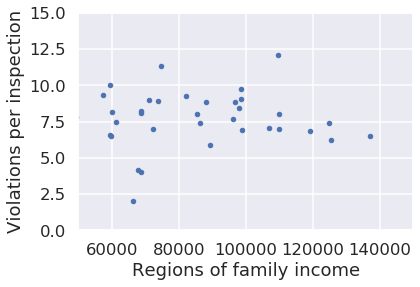

In [7]:
f, ax = plt.subplots()
ax.plot(df['family_income'], df['violations_per_inspect'],'.')
plt.xlabel('Regions of family income'); plt.xlim([50000, 150000]);
plt.ylabel('Violations per inspection'); plt.ylim([0, 15]);

a1, b1 = np.polyfit(df['family_income'], df['violations_per_inspect'], 1)

In [8]:
#Predicting violations per inspection from family income in steps of 5000 dollars

family_income_min = df['family_income'].min()
family_income_max = df['family_income'].max()


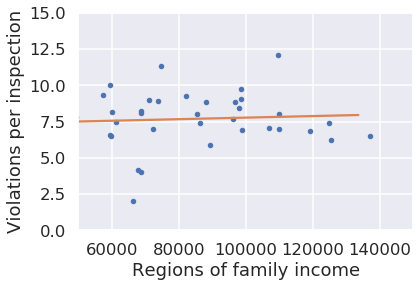

In [9]:
multiplier = np.arange(family_income_min, family_income_max, 5000)

f, ax = plt.subplots()
ax.plot(df['family_income'], df['violations_per_inspect'],'.')
ax.plot(multiplier, a1*multiplier+b1)
plt.xlabel('Regions of family income'); plt.xlim([50000, 150000]);
plt.ylabel('Violations per inspection'); plt.ylim([0, 15]);


In [10]:
outcome_1, predictors_1 = patsy.dmatrices('violations_per_inspect ~ family_income', df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                              OLS Regression Results                              
Dep. Variable:     violations_per_inspect   R-squared:                       0.005
Model:                                OLS   Adj. R-squared:                 -0.025
Method:                     Least Squares   F-statistic:                    0.1598
Date:                    Mon, 08 Jun 2020   Prob (F-statistic):              0.692
Time:                            19:35:27   Log-Likelihood:                -73.847
No. Observations:                      36   AIC:                             151.7
Df Residuals:                          34   BIC:                             154.9
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Interc

The first graph, along with its predicted values, demonstrates that there is no strong correlation between the rates of health inspection violations and family income within a given postal code. This is shown by the extremely large p-value within the OLS Regression. It is interesting to note that the only occurences of below-average violations per health inspection occured in lower family-income regions.

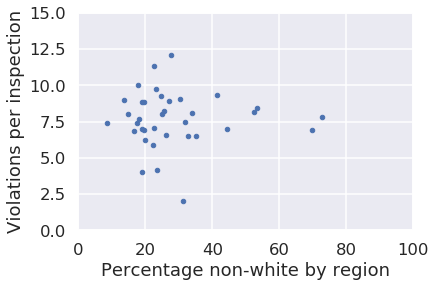

In [11]:
f, ax = plt.subplots()
ax.plot(df['percent_nonwhite'], df['violations_per_inspect'],'.')
plt.xlabel('Percentage non-white by region'); plt.xlim([0, 100]);
plt.ylabel('Violations per inspection'); plt.ylim([0, 15]);

a2, b2 = np.polyfit(df['percent_nonwhite'], df['violations_per_inspect'], 1)

In [12]:
#Predicting violations per inspection from percentage of non-white population

nonwhite_min = df['percent_nonwhite'].min()
nonwhite_max = df['percent_nonwhite'].max()

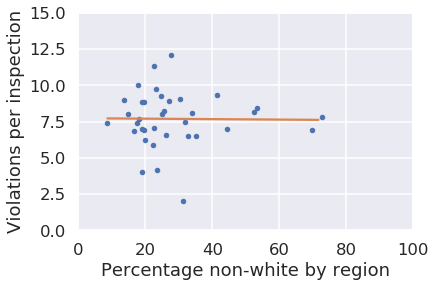

In [13]:
multiplier2 = np.arange(nonwhite_min, nonwhite_max, 1)

f, ax = plt.subplots()
ax.plot(df['percent_nonwhite'], df['violations_per_inspect'],'.')
ax.plot(multiplier2, a2*multiplier2+b2)
plt.xlabel('Percentage non-white by region'); plt.xlim([0, 100]);
plt.ylabel('Violations per inspection'); plt.ylim([0, 15]);



In [14]:
outcome_2, predictors_2 = patsy.dmatrices('violations_per_inspect ~ percent_nonwhite', df)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                              OLS Regression Results                              
Dep. Variable:     violations_per_inspect   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.029
Method:                     Least Squares   F-statistic:                  0.004857
Date:                    Mon, 08 Jun 2020   Prob (F-statistic):              0.945
Time:                            19:35:29   Log-Likelihood:                -73.929
No. Observations:                      36   AIC:                             151.9
Df Residuals:                          34   BIC:                             155.0
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


The linear models for non-white residents and violations per health inspection also did not produce any strong correlations. The predicted values were almost completely consistent throughout the demographic changes

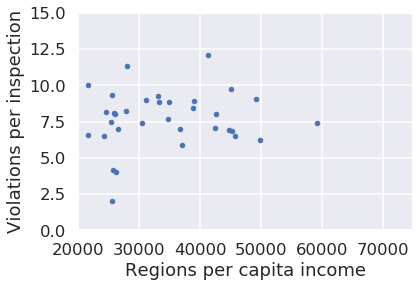

In [15]:
f, ax = plt.subplots()
ax.plot(df['per_capita_income'], df['violations_per_inspect'],'.')
plt.xlabel('Regions per capita income'); plt.xlim([20000, 75000]);
plt.ylabel('Violations per inspection'); plt.ylim([0, 15]);

a3, b3 = np.polyfit(df['per_capita_income'], df['violations_per_inspect'], 1)

In [16]:
#Predicting violations per inspection from per capita income

per_capita_min = df['per_capita_income'].min()
per_capita_max = df['per_capita_income'].max()

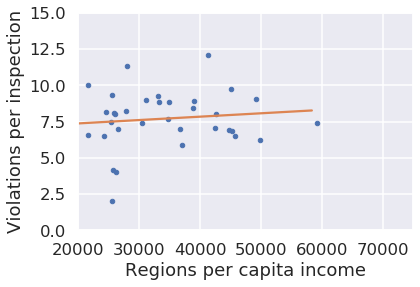

In [17]:
multiplier3 = np.arange(per_capita_min, per_capita_max, 1000)

f, ax = plt.subplots()
ax.plot(df['per_capita_income'], df['violations_per_inspect'],'.')
ax.plot(multiplier3, a3*multiplier3+b3)
plt.xlabel('Regions per capita income'); plt.xlim([20000, 75000]);
plt.ylabel('Violations per inspection'); plt.ylim([0, 15]);


In [18]:
outcome_3, predictors_3 = patsy.dmatrices('violations_per_inspect ~ per_capita_income', df)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                              OLS Regression Results                              
Dep. Variable:     violations_per_inspect   R-squared:                       0.015
Model:                                OLS   Adj. R-squared:                 -0.014
Method:                     Least Squares   F-statistic:                    0.5103
Date:                    Mon, 08 Jun 2020   Prob (F-statistic):              0.480
Time:                            19:35:30   Log-Likelihood:                -73.663
No. Observations:                      36   AIC:                             151.3
Df Residuals:                          34   BIC:                             154.5
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

The final linear model, per capita income, demonstrated the highest predictive power, but not enough to establish significant results. The use of per capita income eliminates a number of potential confounds in the structure of family and households within particular postal code regions. The weak correlation that does exist with per capita income is actually positive, which goes against the initial hypothesis. This raises further questions that could be explored with more detailed data on the restaurants within this dataset.

# Ethics & Privacy

In general, the datasets used are a reflection of a public process that are idealistically intended to bring awareness and transparency for consumers within a given jurisdiction. Because the data is based on institutions rather than individuals, it can be quickly anonymized by eliminating the names of the individual inspectors. The goal is to look for overall patterns, not to discover micro-level patterns within individual people. 

As the goal of the project is to discover bias within the creation of the given dataset, I do not anticipate problems within the use of the data.

The impact of the hypothesized findings is rooted in equitable impact and justice. The nature of the research question leads to a complex web that encompasses race relations, wealth inequality, and government oversight. As such, this project is very much an introductory step to addressing these issues within their respective communities. 

# Conclusion & Discussion

In conclusion, there was no strong correlation found between rates of health violations in restaurants, and the various economic and demographic factors that were used to compare said rates. While the data provided was comprehensive in its level of bureaucratic detail, the features that were analyzed ultimately did not reveal a greater rate of violations in poor or non-white areas.

The data was fitted to various linear models, which did not reveal any strong correlations.

Many of this project's limitations were rooted in the type of data given within the datasets. Information such as whether or not the restaurant belonged to a chain was not given, which could have opened doors to further questions in the realm of socioeconomic equality. 

Ultimately, the results of this project do not discount the existence of any bias within the health inspection process. In addition, the datasets covered only one city, and the difference in health inspection protocol within other jurisdictions could easily produce varying results. 

Food is foundational layer of society. Equal access to quality, safe food is important, and ensuring that said access exists should be a priority for every governing body. 